In [ ]:
!pip install matplotlib

In [ ]:
import pandas as pd

# Train
df = pd.read_csv("datasplit/train_metadata.csv")
df["file_path"] = df["file_path"].str.replace(
    "/content/drive/MyDrive/266/LJSpeech-1.1/wavs",
    "LJSpeech-1.1/wavs",
    regex=False
)
df.to_csv("datasplit/train_metadata.csv", index=False)

# Test
df = pd.read_csv("datasplit/test_metadata.csv")
df["file_path"] = df["file_path"].str.replace(
    "/content/drive/MyDrive/266/LJSpeech-1.1/wavs",
    "LJSpeech-1.1/wavs",
    regex=False
)
df.to_csv("datasplit/test_metadata.csv", index=False)

print("✔ Both manifests updated successfully!")

✔ Both manifests updated successfully!


He had been in the employ of a corn-chandler at Islington, and went into London with his master's cart and horse.


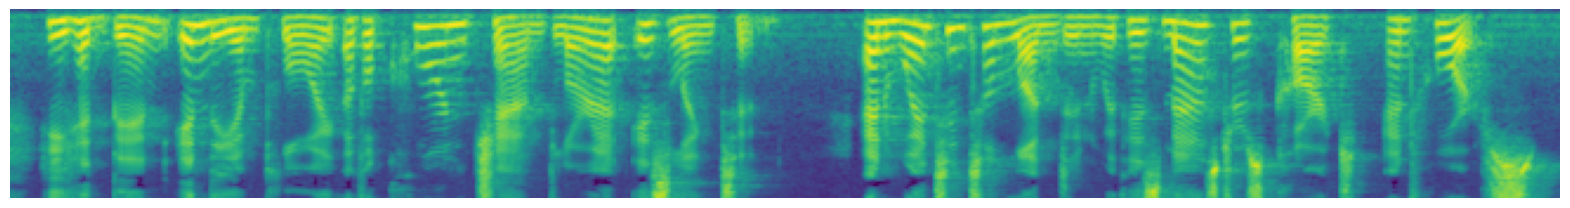

In [ ]:
import numpy as np
from dataset import AudioMelConversions, load_wav
from model import HIFIGANConfig, HIFIGAN
import pandas as pd
import matplotlib.pyplot as plt
import torch
from safetensors.torch import load_file
from IPython.display import Audio
import scipy.io.wavfile as wf
from tqdm.notebook import tqdm

from tacotron2 import Tacotron2Config, Tacotron2
from tokenizer import Tokenizer



index = 0
data = pd.read_csv("datasplit/test_metadata.csv")
path_to_audio = data["file_path"][index]
transcript = data["normalized_transcript"][index]
print(transcript)

audio = load_wav(path_to_audio)

amc = AudioMelConversions()
mel = amc.audio2mel(audio, do_norm=True).unsqueeze(0)

plt.figure(figsize=(20,5))
plt.imshow(mel[0])
plt.axis("off")
plt.show()

## Griffin-Lim

In [ ]:
griffin_audio = amc.mel2audio(mel, do_denorm=True)
Audio(griffin_audio, rate=22050)

## HIFIGAN

In [ ]:
config = HIFIGANConfig()
hifigan = HIFIGAN(config)

file_path = "work_dir/hifigan/final_checkpoint/model.safetensors"
state_dict = load_file(file_path, device="cpu")

success = hifigan.load_state_dict(state_dict)
print(success)
hifigan.eval()

with torch.no_grad():
    gen_audio = hifigan.generator(mel).squeeze().numpy()

Audio(gen_audio, rate=22050)

Effective Upsample Rate: 256
<All keys matched successfully>


## HIFIGAN (Finetuned)

In [ ]:
config = HIFIGANConfig()
ft_hifigan = HIFIGAN(config)

file_path = "work_dir/hifigan_finetune_taco_1/final_checkpoint/model.safetensors"
state_dict = load_file(file_path, device="cpu")

success = ft_hifigan.load_state_dict(state_dict)
print(success)
ft_hifigan.eval()

with torch.no_grad():
    gen_audio = ft_hifigan.generator(mel).squeeze().numpy()

Audio(gen_audio, rate=22050)

Effective Upsample Rate: 256
<All keys matched successfully>


## Tacotron2 + HIFIGAN + FT HIFIGAN

Input Text: I am a student studying Generative Artificial Intelligence.
Griffin Lim


HIFIGAN


FINETUNED HIFIGAN


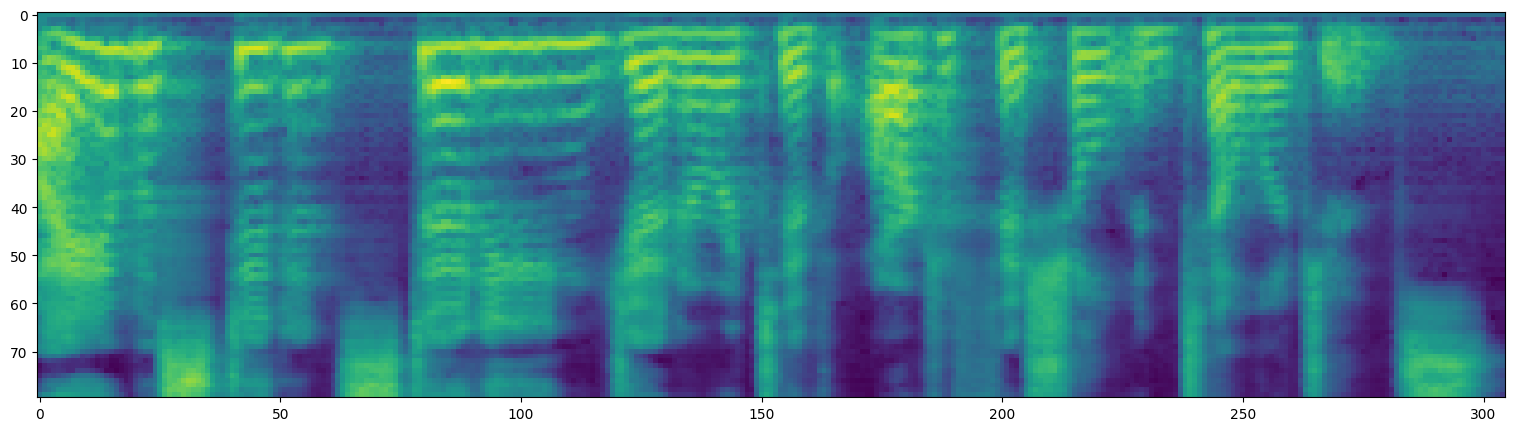

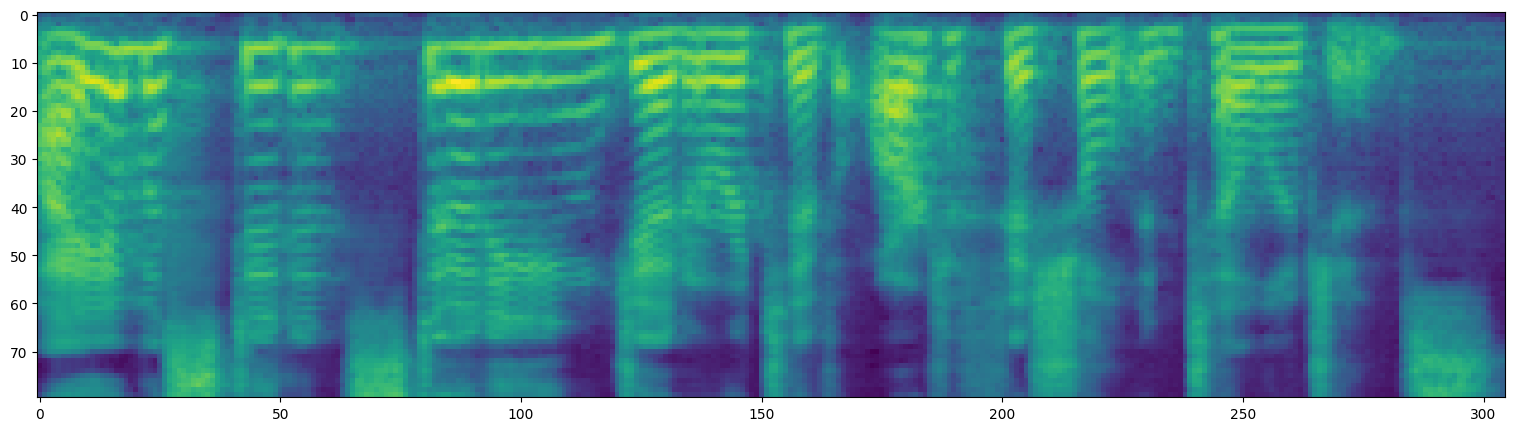

In [ ]:
config = Tacotron2Config()
tacotron2 = Tacotron2(config)
tokenizer = Tokenizer()

state_dict = torch.load('work_dir/taco_weights/taco_model.bin', map_location=torch.device('cpu'))
tacotron2.load_state_dict(state_dict)
tacotron2.eval()

def inference(text):
    print(f"Input Text: {text}")

    tokens = tokenizer.encode(text).unsqueeze(0)
    output, alignments  = tacotron2.inference(tokens)
    output = output.transpose(1,2)

    ### Griffin Lim ###
    print("Griffin Lim")
    griffin_audio = amc.mel2audio(output[0], do_denorm=True)
    display(Audio(griffin_audio, rate=22050))

    ### HIFIGAN ###
    print("HIFIGAN")
    with torch.no_grad():
        gen_audio = hifigan.generator(output).squeeze().numpy()
    display(Audio(gen_audio, rate=22050))

    ### FT HIFIGAN ###
    print("FINETUNED HIFIGAN")
    with torch.no_grad():
        gen_audio2 = ft_hifigan.generator(output).squeeze().numpy()
    display(Audio(gen_audio2, rate=22050))

    plt.figure(figsize=(25,5))
    plt.imshow(amc.audio2mel(gen_audio))
    plt.show()

    plt.figure(figsize=(25,5))
    plt.imshow(amc.audio2mel(gen_audio2))
    plt.show()

inference("I am a student studying Generative Artificial Intelligence.")

In [ ]:
!pip install ipywidgets

In [ ]:
import os

def inference(text):

    tokens = tokenizer.encode(text).unsqueeze(0)
    output, alignments  = tacotron2.inference(tokens)
    output = output.transpose(1,2)

    ### Griffin Lim ###
    griffin_audio = amc.mel2audio(output[0], do_denorm=True)

    ### HIFIGAN ###
    with torch.no_grad():
        gen_audio = hifigan.generator(output).squeeze().numpy()

    ### FT HIFIGAN ###
    with torch.no_grad():
        gen_audio_ft = ft_hifigan.generator(output).squeeze().numpy()

    return griffin_audio, gen_audio, gen_audio_ft

# Create directories if they don't exist
os.makedirs("work_dir/gens/gl", exist_ok=True)
os.makedirs("work_dir/gens/hf", exist_ok=True)
os.makedirs("work_dir/gens/hfft", exist_ok=True)

for i, text in tqdm(enumerate(data["normalized_transcript"]), total=len(data)):
    a, b, c = inference(text)

    wf.write(f"work_dir/gens/gl/{i}.wav", rate=22050, data=a)
    wf.write(f"work_dir/gens/hf/{i}.wav", rate=22050, data=b)
    wf.write(f"work_dir/gens/hfft/{i}.wav", rate=22050, data=c)

  0%|          | 0/131 [00:00<?, ?it/s]

Reached Max Decoder Steps
Reached Max Decoder Steps
Reached Max Decoder Steps
